In [1]:
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
from xopt import Xopt
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
from xopt.generators import UpperConfidenceBoundGenerator, ExpectedImprovementGenerator
from xopt.generators.bayesian.options import ModelOptions
from xopt.generators.bayesian.expected_improvement import BayesianOptions
from xopt.generators.bayesian.upper_confidence_bound import UCBOptions
from lume_model.torch import LUMEModule

from utils import NegativeTransverseBeamSize
from utils import load_surrogate, load_corr_model, create_vocs, print_runtime, running_max
from dynamic_custom_mean import Flatten, OccasionalConstant, OccasionalModel

In [2]:
# define prior mean
mean_class = Flatten
mean_kwargs = {"w_lim": (0.0, 1.0), "step_range": (0, 10)}
n_epoch = 5

In [3]:
# BO configuration
acq_name = "EI"  # "EI" or "UCB"
n_init = 3
n_step = 50

In [4]:
# load surrogate model and define objective
surrogate = load_surrogate("configs/lcls_variables.yml", "configs/normalization.json", "torch_model.pt")
surrogate._model.eval()
surrogate._model.requires_grad_(False)

objective_name = "negative_sigma_xy"
vocs = create_vocs(surrogate, objective_name)

surrogate_module = LUMEModule(surrogate, vocs.variable_names, ["sigma_x", "sigma_y"])
surrogate_module.eval()
surrogate_module.requires_grad_(False)

Objective = NegativeTransverseBeamSize
ground_truth = Objective(surrogate_module)

# Xopt evaluator function
def evaluate(input_dict):
    model_result = surrogate.evaluate(input_dict)
    obj_kwargs = {key:model_result[key] for key in surrogate_module.output_order}
    obj_value = Objective.function(**obj_kwargs).detach().item()
    return {objective_name: obj_value}

In [5]:
# load correlated model
corr_model = load_corr_model(
    "configs/lcls_variables.yml",
    "corr_models/x_transformer.pt",
    "corr_models/y_transformer.pt",
    "corr_models/{:d}ep.pt".format(n_epoch)
)
corr_model._model.eval()
corr_model._model.requires_grad_(False)

corr_module = LUMEModule(corr_model, vocs.variable_names,
                         ["sigma_x", "sigma_y"])
corr_module.eval()
corr_module.requires_grad_(False)
mean_kwargs["model"] = Objective(corr_module)

In [6]:
# generate initial data set
inputs_init = [vocs.random_inputs() for _ in range(n_init)]
outputs_init = [evaluate(input_dict)[objective_name] for input_dict in inputs_init]
data_init = pd.DataFrame(inputs_init)
data_init[objective_name] = outputs_init
data_init

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy
0,0.258416,4.109017,0.211682,-0.006705,0.004791,-8.758396,-7.841335,2.162188,-2.744066,6.062956,-2.309843,-4.394092,5.109642,250.0,58000000.0,70000000.0,-2.031932
1,0.251895,11.201739,0.242101,-0.008445,-0.006806,-23.490331,6.272958,1.161672,-2.397871,3.632379,-4.077292,-2.601814,5.295804,250.0,58000000.0,70000000.0,-0.995653
2,0.333537,11.533788,0.216209,0.008951,-0.007714,-0.441780,1.068291,3.267747,-1.096251,1.870839,-0.724927,-2.189743,4.793663,250.0,58000000.0,70000000.0,-3.417738


In [7]:
# run BO
t0 = time.time()
run_data = data_init.copy()
for i_step in range(n_step):

    # define prior mean
    mean_kwargs["step"] = i_step
    custom_mean = mean_class(**mean_kwargs)

    # run Xopt
    model_options = ModelOptions(
        name="trainable_mean_standard",
        mean_modules={objective_name: custom_mean},
    )
    if acq_name == "EI":
        generator_options = BayesianOptions(model=model_options)
        generator = ExpectedImprovementGenerator(vocs, options=generator_options)
    else:
        generator_options = UCBOptions(model=model_options)
        generator = UpperConfidenceBoundGenerator(vocs, options=generator_options)
    evaluator = Evaluator(function=evaluate)
    X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs, data=run_data)
    X.step()

    # update data set
    run_data.loc[len(run_data.index)] = X.data.iloc[-1]

# print runtime
print_runtime(t0, time.time())

Runtime: 12.98 sec


In [8]:
# print data set
X.data

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy,xopt_runtime,xopt_error
0,0.258416,4.109017,0.211682,-0.006705,0.004791,-8.758396,-7.841335,2.162188,-2.744066,6.062956,-2.309843,-4.394092,5.109642,250.0,58000000.0,70000000.0,-2.031932,NaN,NaN
1,0.251895,11.201739,0.242101,-0.008445,-0.006806,-23.490331,6.272958,1.161672,-2.397871,3.632379,-4.077292,-2.601814,5.295804,250.0,58000000.0,70000000.0,-0.995653,NaN,NaN
2,0.333537,11.533788,0.216209,0.008951,-0.007714,-0.441780,1.068291,3.267747,-1.096251,1.870839,-0.724927,-2.189743,4.793663,250.0,58000000.0,70000000.0,-3.417738,NaN,NaN
3,0.298053,7.271790,0.230194,-0.006814,0.002533,4.433449,6.484167,2.996418,-2.237998,1.464097,-3.930044,-3.632718,3.875245,250.0,58000000.0,70000000.0,-2.081037,NaN,NaN
4,0.295317,10.669199,0.217416,0.001459,0.007813,-9.551782,-4.676781,3.335564,-2.164583,6.443370,-5.046278,-6.590767,4.138742,250.0,58000000.0,70000000.0,-2.633041,NaN,NaN
5,0.274119,7.999582,0.233247,0.005728,-0.007865,-17.862220,1.331497,1.746907,-3.101095,5.641359,-2.540942,-3.103863,5.013024,250.0,58000000.0,70000000.0,-2.334361,NaN,NaN
6,0.318920,3.734360,0.247572,0.006814,-0.002234,-23.270540,-4.430123,3.217143,-3.689909,2.107246,-2.023228,-1.688698,6.958436,250.0,58000000.0,70000000.0,-2.940776,NaN,NaN
7,0.294936,4.015902,0.213501,-0.004461,-0.009275,4.326144,7.075319,2.068567,-3.890487,3.525011,0.216042,-6.180183,2.487300,250.0,58000000.0,70000000.0,-4.794883,NaN,NaN
8,0.357924,10.477965,0.212323,0.002487,0.001738,-18.171746,5.458393,3.867051,-1.091579,4.814488,-3.995986,0.522517,4.100642,250.0,58000000.0,70000000.0,-1.848287,NaN,NaN
9,0.424168,8.362278,0.237183,0.006246,-0.003363,-2.869532,-9.789188,3.043183,-1.447918,5.116363,-6.483846,-5.238028,1.729888,250.0,58000000.0,70000000.0,-1.214008,NaN,NaN


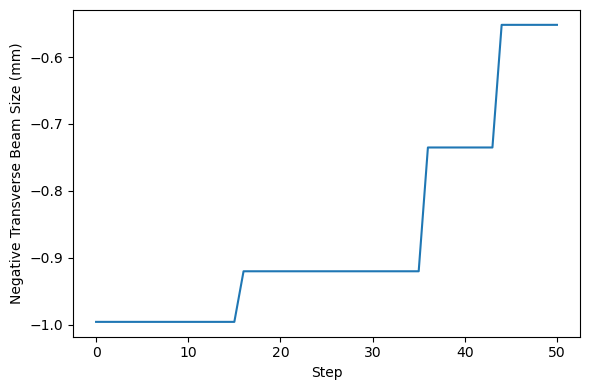

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x = torch.arange(n_step + 1)
y = torch.from_numpy(run_data[objective_name].values)
ax.plot(x, running_max(y.squeeze())[n_init - 1:], "C0-")
ax.set_xlabel("Step")
ax.set_ylabel("{} ({})".format(ground_truth.name, ground_truth.unit))
fig.tight_layout()